In [1]:
import pandas as pd
import numpy as np
import pybaseball as pb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df_2023 = pd.read_csv("C:/Users/wampl/sxwOBA/statcast_data/2023.csv")
sample_df = df_2023.sample(n=10000)
sample_df.to_csv('C:/Users/wampl/sxwOBA/statcast_data/sample_2023.csv', index=False)

In [3]:
df1 = pd.read_csv("C:/Users/wampl/sxwOBA/statcast_data/woba_events_2021.csv")
df2 = pd.read_csv("C:/Users/wampl/sxwOBA/statcast_data/woba_events_2022.csv")
df3 = pd.read_csv("C:/Users/wampl/sxwOBA/statcast_data/woba_events_2023.csv")

In [4]:
df1.groupby(['player_name', 'pitcher'], as_index=False)['sxwOBA_adj'].agg(['mean', 'count']).sort_values('count', ascending=False).head(20)

,,mean,count
player_name,pitcher,,
"Wheeler, Zack",554430,0.252290,839
"Alcantara, Sandy",645261,0.290125,833
"Wainwright, Adam",425794,0.291865,821
"Buehler, Walker",621111,0.265490,801
"Castillo, Luis",622491,0.292706,788
"Berríos, José",621244,0.295329,779
"Hendricks, Kyle",543294,0.334386,778
"Gausman, Kevin",592332,0.285899,771
"Ray, Robbie",592662,0.290476,770


In [5]:
df2.groupby(['player_name', 'pitcher'], as_index=False)['sxwOBA_adj'].agg(['mean', 'count']).sort_values('count', ascending=False).head(20)

,,mean,count
player_name,pitcher,,
"Bieber, Shane",669456,0.271133,288
"Kelly, Merrill",518876,0.335800,279
"Alcantara, Sandy",645261,0.279491,278
"Lynn, Lance",458681,0.280222,276
"Burnes, Corbin",669203,0.289955,274
"Wainwright, Adam",425794,0.345703,273
"Stroman, Marcus",573186,0.280013,266
"Gausman, Kevin",592332,0.280472,261
"Darvish, Yu",506433,0.269839,257


In [6]:
df2.groupby(['player_name', 'pitcher'], as_index=False)[['estimated_woba_using_speedangle', 'xwOBA_adj']].agg(['mean', 'count']).sort_values(('estimated_woba_using_speedangle', 'count'), ascending=False).round(3).head(20)

estimated_woba_using_speedangle       xwOBA_adj  \
                                                      mean count      mean   
player_name        pitcher                                                   
Bieber, Shane      669456                            0.287   288     0.271   
Kelly, Merrill     518876                            0.332   279     0.321   
Alcantara, Sandy   645261                            0.275   278     0.262   
Lynn, Lance        458681                            0.276   277     0.263   
Burnes, Corbin     669203                            0.292   274     0.278   
Wainwright, Adam   425794                            0.335   273     0.324   
Stroman, Marcus    573186                            0.286   266     0.269   
Gausman, Kevin     592332                            0.269   261     0.257   
Manoah, Alek       666201                            0.287   257     0.277   
Darvish, Yu        506433                            0.280   257     0.270   
Pérez, Martín      527048                            0.319   256     0.306   
Montgomery, Jordan 656756                            0.299   255     0.285   
Irvin, Cole        608344                            0.328   255     0.315   
Valdez, Framber    664285                            0.291   254     0.274   
Quantrill, Cal     615698                            0.295   253     0.281   
McKenzie, Triston  663474                            0.272   252     0.263   
Bradish, Kyle      680694                            0.296   252     0.283   
Márquez, Germán    608566                            0.305   250     0.292   
Singer, Brady      663903                            0.317   249     0.302   
Snell, Blake       605483                            0.267   247     0.258   

                                  
                           count  
player_name        pitcher        
Bieber, Shane      669456    288  
Kelly, Merrill     518876    279  
Alcantara, Sandy   645261    278  
Lynn, Lance        458681    277  
Burnes, Corbin     669203    274  
Wainwright, Adam   425794    273  
Stroman, Marcus    573186    266  
Gausman, Kevin     592332    261  
Manoah, Alek       666201    257  
Darvish, Yu        506433    257  
Pérez, Martín      527048    256  
Montgomery, Jordan 656756    255  
Irvin, Cole        608344    255  
Valdez, Framber    664285    254  
Quantrill, Cal     615698    253  
McKenzie, Triston  663474    252  
Bradish, Kyle      680694    252  
Márquez, Germán    608566    250  
Singer, Brady      663903    249  
Snell, Blake       605483    247

In [7]:
leaders_23 = df3.groupby(['player_name', 'pitcher'], as_index=False)['xwOBA_adj', 'sxwOBA_adj'].mean()


C:\Users\wampl\AppData\Local\Temp\ipykernel_22648\1807637183.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  leaders_23 = df3.groupby(['player_name', 'pitcher'], as_index=False)['xwOBA_adj', 'sxwOBA_adj'].mean()


In [8]:
df3.events.value_counts(normalize=True).round(2)

field_out                    0.40
strikeout                    0.23
single                       0.14
walk                         0.08
double                       0.05
home_run                     0.03
force_out                    0.02
grounded_into_double_play    0.02
hit_by_pitch                 0.01
sac_fly                      0.01
field_error                  0.01
triple                       0.00
double_play                  0.00
fielders_choice              0.00
fielders_choice_out          0.00
strikeout_double_play        0.00
sac_fly_double_play          0.00
triple_play                  0.00
Name: events, dtype: float64

In [9]:
df3['xwOBA_adj'].mean()

0.3077622369770019

In [10]:
def get_mlbam_id(row):
    """
    Attempts to find the mlbam id for a player using their fangraphs id and name
    """
    # First try fuzzy lookup using player first and last name
    result = pb.playerid_lookup(row['last_name'], row['first_name'], fuzzy=True)
    try:
        # If there are multiple results, try to find the one that matches the fangraphs id
        result = result.loc[result['key_fangraphs'] == row['IDfg']].iloc[0]
        return result['key_mlbam']
    except:
        # If no match, try reverse lookup using fangraphs id
        try:
            print('failed to find mlbam id for', row['Name'], row['last_name'], row['first_name'])
            print('trying reverse lookup')
            result = pb.playerid_reverse_lookup([row['IDfg']], key_type='fangraphs').iloc[0]
            return result['key_mlbam']
        except:
        # If no match, try to find the player with the same name that played in the mlb most recently
            result['mlb_played_last'].replace('', np.nan, inplace=True)
            result = result.loc[result['mlb_played_last'] > 2015].iloc[0]
            if len(result) != 0:
                return result['key_mlbam']
            else:
                return 000000

In [11]:
def get_fg_stats(year, selected_stats):
    import pybaseball as pb
    """
    returns fangraphs batting stats for a given year
    """
    out = pb.fg_pitching_data(year, qual=20)
    out['first_name'] = out['Name'].str.split(n=1).str[0]
    out['last_name'] = out['Name'].str.split(n=1).str[1]
    out['key_mlbam'] = out.apply(get_mlbam_id, axis=1)
    out.dropna(subset=['key_mlbam'], inplace=True)
    return out[selected_stats]


In [12]:
pitching_23 = get_fg_stats(2023, ['Name', 'IP', 'ERA', 'FIP', 'xFIP', 'SIERA', 'xERA', 'GB%', 'key_mlbam'])

No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
failed to find mlbam id for Carlos Hernandez Hernandez Carlos
trying reverse lookup
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 

In [13]:
pitching_23.head()

,Name,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam
199,Zack Wheeler,118.1,3.88,2.88,3.47,3.47,3.27,0.396,554430
114,Kevin Gausman,121.2,3.18,2.77,2.91,3.00,3.65,0.426,592332
137,Zac Gallen,136.2,3.36,3.16,3.55,3.63,3.84,0.379,668678
180,Spencer Strider,123.0,3.73,2.97,2.67,2.55,3.08,0.327,675911
126,Framber Valdez,126.0,3.29,3.20,3.14,3.46,4.06,0.535,664285


In [14]:
df_2023 = pd.merge(leaders_23, pitching_23, left_on='pitcher', right_on='key_mlbam', how='left')
df_2023.head()

,player_name,pitcher,xwOBA_adj,sxwOBA_adj,Name,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam
0,"Abad, Fernando",472551,0.421655,0.525158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Abbott, Andrew",671096,0.288144,0.294499,Andrew Abbott,61.2,1.90,3.75,4.30,4.05,3.35,0.253,671096.0
2,"Abbott, Cory",676265,0.315990,0.325780,Cory Abbott,21.1,5.91,5.96,5.04,4.89,5.05,0.446,676265.0
3,"Abreu, Albert",656061,0.302496,0.318008,Albert Abreu,42.0,4.07,4.76,4.45,4.10,4.12,0.469,656061.0
4,"Abreu, Bryan",650556,0.268908,0.277058,Bryan Abreu,48.1,2.61,3.24,2.94,2.70,3.20,0.363,650556.0


In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
runs_per_nine_2023 = 4.31


df_2023['xERA_adj'] = round(runs_per_nine_2023 * ((df_2023['xwOBA_adj'] / df3['xwOBA_adj'].mean())**2), 2)
df_2023['sxERA_adj'] = round(runs_per_nine_2023 * ((df_2023['sxwOBA_adj'] / df3['sxwOBA_adj'].mean())**2), 2)

In [17]:
df_2023 = df_2023.dropna()

In [18]:
df_2023.sort_values('IP', ascending=False).head(50).round(2)

,player_name,pitcher,xwOBA_adj,sxwOBA_adj,Name,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam,xERA_adj,sxERA_adj
228,"Gallen, Zac",668678,0.30,0.29,Zac Gallen,136.2,3.36,3.16,3.55,3.63,3.84,0.38,668678.0,3.97,3.69
14,"Alcantara, Sandy",645261,0.30,0.31,Sandy Alcantara,135.1,4.46,3.87,4.00,4.25,4.29,0.50,645261.0,4.15,4.01
733,"Webb, Logan",657277,0.27,0.28,Logan Webb,134.1,3.48,3.41,2.95,3.17,3.52,0.60,657277.0,3.43,3.35
503,"Nola, Aaron",605400,0.29,0.29,Aaron Nola,133.1,4.25,4.23,3.76,3.82,3.68,0.42,605400.0,3.81,3.73
138,"Cole, Gerrit",543037,0.28,0.29,Gerrit Cole,129.1,2.78,3.34,3.67,3.67,3.60,0.38,543037.0,3.68,3.54
414,"López, Pablo",641154,0.27,0.27,Pablo Lopez,128.2,4.13,3.49,3.47,3.38,3.25,0.40,641154.0,3.25,3.19
344,"Keller, Mitch",656605,0.30,0.31,Mitch Keller,128.0,4.01,3.80,3.72,3.83,3.70,0.45,656605.0,3.97,4.14
459,"Mikolas, Miles",571945,0.33,0.32,Miles Mikolas,127.1,4.38,3.90,4.68,4.78,4.95,0.38,571945.0,4.86,4.47
98,"Burnes, Corbin",669203,0.27,0.28,Corbin Burnes,127.1,3.46,3.83,3.92,4.03,3.27,0.43,669203.0,3.30,3.33
242,"Gibson, Kyle",502043,0.31,0.31,Kyle Gibson,127.0,4.68,3.85,4.30,4.53,4.56,0.48,502043.0,4.32,4.17


In [19]:
df_2023.corr()

C:\Users\wampl\AppData\Local\Temp\ipykernel_22648\4051704210.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_2023.corr()


,pitcher,xwOBA_adj,sxwOBA_adj,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam,xERA_adj,sxERA_adj
pitcher,1.000000,0.020053,0.025939,-0.105310,0.052462,0.035615,0.028305,0.015931,0.022223,0.014431,1.000000,0.017779,0.024811
xwOBA_adj,0.020053,1.000000,0.955046,0.045841,0.696979,0.798668,0.720736,0.764649,0.969347,-0.226137,0.020053,0.995655,0.949724
sxwOBA_adj,0.025939,0.955046,1.000000,-0.004829,0.720753,0.807020,0.692915,0.728177,0.934318,-0.169063,0.025939,0.950755,0.996084
IP,-0.105310,0.045841,-0.004829,1.000000,-0.077499,-0.048118,-0.103873,0.049498,0.007517,-0.041963,-0.105310,0.026247,-0.026343
ERA,0.052462,0.696979,0.720753,-0.077499,1.000000,0.697541,0.542842,0.555490,0.717842,-0.156915,0.052462,0.700229,0.725845
FIP,0.035615,0.798668,0.807020,-0.048118,0.697541,1.000000,0.787295,0.755759,0.792344,-0.248166,0.035615,0.795718,0.807734
xFIP,0.028305,0.720736,0.692915,-0.103873,0.542842,0.787295,1.000000,0.934977,0.688728,-0.384802,0.028305,0.717566,0.689621
SIERA,0.015931,0.764649,0.728177,0.049498,0.555490,0.755759,0.934977,1.000000,0.746823,-0.217946,0.015931,0.761806,0.724000
xERA,0.022223,0.969347,0.934318,0.007517,0.717842,0.792344,0.688728,0.746823,1.000000,-0.155395,0.022223,0.977923,0.941090
GB%,0.014431,-0.226137,-0.169063,-0.041963,-0.156915,-0.248166,-0.384802,-0.217946,-0.155395,1.000000,0.014431,-0.223827,-0.168087


In [20]:
df3.groupby(['player_name'], as_index=False)['sxwOBA', 'sxwOBA_adj', 'launch_speed', 'launch_angle', 'gidp_prob'].agg(['mean', 'count', 'sum']).sort_values(('gidp_prob', 'sum'), ascending=False).head(20)

C:\Users\wampl\AppData\Local\Temp\ipykernel_22648\1416161095.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df3.groupby(['player_name'], as_index=False)['sxwOBA', 'sxwOBA_adj', 'launch_speed', 'launch_angle', 'gidp_prob'].agg(['mean', 'count', 'sum']).sort_values(('gidp_prob', 'sum'), ascending=False).head(20)


sxwOBA                   sxwOBA_adj                    \
                      mean count         sum       mean count         sum   
player_name                                                                 
Webb, Logan       0.297059   580  172.293943   0.279146   580  161.904775   
Stroman, Marcus   0.312776   534  167.022527   0.296004   534  158.066285   
Alcantara, Sandy  0.320185   588  188.268641   0.305010   588  179.345818   
Elder, Bryce      0.314790   498  156.765232   0.297395   498  148.102918   
Valdez, Framber   0.311612   537  167.335845   0.295926   537  158.912443   
Corbin, Patrick   0.384430   558  214.512125   0.369663   558  206.272078   
Gibson, Kyle      0.325947   559  182.204150   0.311371   559  174.056486   
Singer, Brady     0.351116   525  184.336120   0.336087   525  176.445614   
Cobb, Alex        0.337409   474  159.931879   0.321429   474  152.357314   
Mikolas, Miles    0.335398   573  192.182894   0.322273   573  184.662197   
Gray, Sonny       0.310589   518  160.885021   0.296546   518  153.610736   
Bieber, Shane     0.347029   485  168.309218   0.332225   485  161.129300   
Oviedo, Johan     0.330900   539  178.355174   0.317750   539  171.267024   
Gomber, Austin    0.372841   484  180.455013   0.358256   484  173.395939   
Keller, Mitch     0.321890   591  190.237210   0.309955   591  183.183278   
Steele, Justin    0.296022   470  139.130228   0.281049   470  132.093263   
Kirby, George     0.313110   513  160.625214   0.299409   513  153.597018   
Eflin, Zach       0.280127   477  133.620589   0.265547   477  126.666052   
Bello, Brayan     0.328273   429  140.829286   0.312073   429  133.879516   
Brown, Hunter     0.308152   465  143.290512   0.293295   465  136.382331   

                 launch_speed                launch_angle                \
                         mean count      sum         mean count     sum   
player_name                                                               
Webb, Logan         90.394595   407  36790.6     2.202934   409   901.0   
Stroman, Marcus     90.166307   371  33451.7     2.451613   372   912.0   
Alcantara, Sandy    88.432009   428  37848.9     7.343458   428  3143.0   
Elder, Bryce        89.624590   366  32802.6     7.647541   366  2799.0   
Valdez, Framber     91.451676   358  32739.7     3.446927   358  1234.0   
Corbin, Patrick     90.272222   432  38997.6    10.298611   432  4449.0   
Gibson, Kyle        88.775556   405  35954.1     8.758025   405  3547.0   
Singer, Brady       91.513032   376  34408.9     9.321809   376  3505.0   
Cobb, Alex          89.304451   337  30095.6     0.759644   337   256.0   
Mikolas, Miles      89.927354   446  40107.6    14.327354   446  6390.0   
Gray, Sonny         88.666189   349  30944.5     9.040115   349  3155.0   
Bieber, Shane       91.258989   356  32488.2     9.528090   356  3392.0   
Oviedo, Johan       88.626486   370  32791.8    10.040541   370  3715.0   
Gomber, Austin      90.411497   374  33813.9    11.069333   375  4151.0   
Keller, Mitch       86.977949   390  33921.4    10.061538   390  3924.0   
Steele, Justin      86.346131   336  29012.3    10.291667   336  3458.0   
Kirby, George       88.902387   377  33516.2    12.551724   377  4732.0   
Eflin, Zach         86.276855   337  29075.3     8.082840   338  2732.0   
Bello, Brayan       89.657655   307  27524.9     5.824104   307  1788.0   
Brown, Hunter       90.260606   297  26807.4     5.895623   297  1751.0   

                 gidp_prob                   
                      mean count        sum  
player_name                                  
Webb, Logan       0.039271   407  15.983337  
Stroman, Marcus   0.037240   370  13.778835  
Alcantara, Sandy  0.032073   428  13.727421  
Elder, Bryce      0.036412   366  13.326639  
Valdez, Framber   0.036300   357  12.959080  
Corbin, Patrick   0.029345   432  12.676996  
Gibson, Kyle      0.031027   404  12.534869  
Singer, Brady     0.032285   376  12.139241  
Cobb, Alex      

In [21]:
def get_sum_gidp_probs(player_name):
    return df.loc[df['player_name']==player_name, 'gidp_prob'].sum().round()

In [35]:
df3['xDP'] = df3.apply(lambda row: get_sum_gidp_probs(df3, row['player_name']))

KeyError: 'player_name'

In [22]:
get_sum_gidp_probs(df3, 'Webb, Logan')

16.0

In [23]:
get_sum_gidp_probs(df3, 'Stroman, Marcus')

14.0

In [24]:
get_sum_gidp_probs(df3, 'Elder, Bryce')

13.0

In [25]:
get_sum_gidp_probs(df3, 'Cobb, Alex')

12.0

In [26]:
import plotly.express as px

px.scatter(df_2023.loc[df_2023['IP']>20], x='xERA_adj', y='sxERA_adj', color='GB%', hover_name='Name', hover_data=['ERA', 'xERA'], trendline='ols')

In [33]:
px.scatter(df_2023.loc[df_2023['IP']>50], x='xERA', y='xERA_adj', color='GB%', hover_name='Name', hover_data=['ERA', 'xERA', 'sxERA_adj'], trendline='ols')

In [28]:
df3.loc[(df3['player_name']=='Cobb, Alex') & (df3['events']=='grounded_into_double_play'), ['rf_xwoba', 'sxwOBA', 'gidp_prob', 'gidp_adj', 'sxwOBA_adj', 'xwOBA_adj', 'estimated_woba_using_speedangle']].head(20).round(3)

,rf_xwoba,sxwOBA,gidp_prob,gidp_adj,sxwOBA_adj,xwOBA_adj,estimated_woba_using_speedangle
22522,0.114,0.163,0.084,-0.055,0.109,0.079,0.134
34270,0.151,0.153,0.082,-0.053,0.100,0.079,0.132
34278,0.111,0.053,0.085,-0.055,-0.002,0.009,0.064
40530,0.079,0.049,0.079,-0.051,-0.002,0.060,0.111
46215,0.106,0.056,0.070,-0.045,0.010,0.034,0.079
46235,0.106,0.062,0.070,-0.045,0.017,0.024,0.069
50834,0.601,0.622,0.040,-0.026,0.596,0.494,0.520
56470,0.123,0.206,0.079,-0.052,0.155,0.182,0.234
62787,0.214,0.248,0.079,-0.052,0.197,0.213,0.265
80330,0.242,0.211,0.079,-0.052,0.160,0.192,0.244


In [29]:
df3.loc[:, ['rf_xwoba', 'sxwOBA', 'gidp_prob', 'gidp_adj', 'sxwOBA_adj', 'xwOBA_adj', 'estimated_woba_using_speedangle']].mean()

rf_xwoba                           0.327407
sxwOBA                             0.328423
gidp_prob                          0.027404
gidp_adj                          -0.011989
sxwOBA_adj                         0.316396
xwOBA_adj                          0.307762
estimated_woba_using_speedangle    0.319782
dtype: float64

In [30]:
df3.loc[df3['player_name']=='Cobb, Alex', ['rf_xwoba', 'sxwOBA', 'gidp_prob', 'gidp_adj', 'sxwOBA_adj', 'xwOBA_adj', 'estimated_woba_using_speedangle']].mean()

rf_xwoba                           0.334556
sxwOBA                             0.337409
gidp_prob                          0.034579
gidp_adj                          -0.015980
sxwOBA_adj                         0.321429
xwOBA_adj                          0.307594
estimated_woba_using_speedangle    0.323574
dtype: float64

In [31]:
df_2023.loc[df_2023['IP']>50].sort_values('sxERA', ascending=True).reset_index().sort_values('diff', ascending=False).head(20)

KeyError: 'sxERA'

In [ ]:
df3.groupby('pitcher_team')['xERA', 'xERA_adj', 'sxwOBA_adj'].mean()

C:\Users\wampl\AppData\Local\Temp\ipykernel_21200\4108902400.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



KeyError: "Columns not found: 'xERA', 'xERA_adj'"

In [ ]:
df3.groupby('pitch_type')['sxwOBA', 'sxwOBA_adj'].mean()

C:\Users\wampl\AppData\Local\Temp\ipykernel_21200\3978275196.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,sxwOBA,sxwOBA_adj
pitch_type,,
CH,0.302542,0.295533
CS,0.217032,0.210069
CU,0.287562,0.281881
EP,0.498885,0.493780
FA,0.455321,0.449930
FC,0.350624,0.344367
FF,0.359642,0.355020
FO,0.192533,0.189185
FS,0.263834,0.257279


In [ ]:
df2.groupby('pitch_type')['sxwOBA', 'sxwOBA_adj'].mean()

C:\Users\wampl\AppData\Local\Temp\ipykernel_21200\2529269680.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,sxwOBA,sxwOBA_adj
pitch_type,,
CH,0.297299,0.290311
CS,0.367528,0.362529
CU,0.281527,0.276038
EP,0.456227,0.450593
FA,0.481876,0.476874
FC,0.335985,0.329815
FF,0.350966,0.346447
FS,0.245195,0.238466
KC,0.277225,0.270803


<AxesSubplot: xlabel='launch_angle', ylabel='is_gidp'>

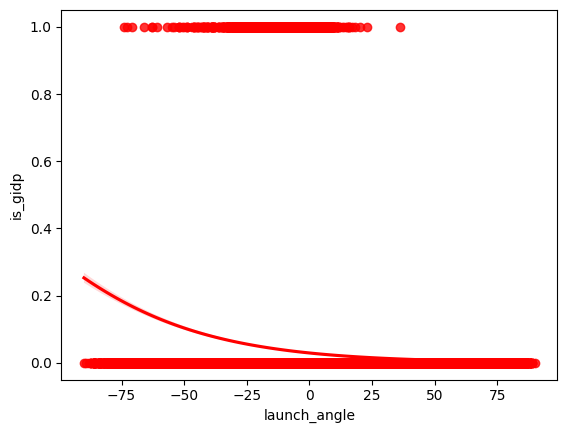

In [ ]:
df3['is_gidp'] = df3['events'].isin(['grounded_into_double_play'])
sns.regplot(data=df3, x='launch_angle', y='is_gidp', color='red', logistic=True)

In [ ]:
df_2023['xERA'].describe()

count    20.000000
mean      4.110500
std       0.763093
min       3.090000
25%       3.567500
50%       3.920000
75%       4.550000
max       6.260000
Name: xERA, dtype: float64

In [ ]:
df_2023['sxERA'].describe()

count    20.000000
mean      3.948000
std       0.497368
min       3.200000
25%       3.582500
50%       3.945000
75%       4.277500
max       5.170000
Name: sxERA, dtype: float64

In [ ]:
df_2023.corr()

C:\Users\wampl\AppData\Local\Temp\ipykernel_3736\4051704210.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,pitcher,xwOBA_adj,sxwOBA_adj,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam,xERA_adj,sxERA_adj
pitcher,1.000000,0.016667,0.026202,-0.088847,0.032831,0.017176,0.023368,0.014750,0.006024,0.003726,1.000000,0.015278,0.025568
xwOBA_adj,0.016667,1.000000,0.956401,0.062140,0.697600,0.797798,0.694138,0.747240,0.968463,-0.183998,0.016667,0.995594,0.949980
sxwOBA_adj,0.026202,0.956401,1.000000,0.008291,0.720495,0.803253,0.674300,0.721301,0.935770,-0.123597,0.026202,0.953319,0.995939
IP,-0.088847,0.062140,0.008291,1.000000,-0.065054,-0.037001,-0.087888,0.070458,0.020091,-0.025679,-0.088847,0.043970,-0.012085
ERA,0.032831,0.697600,0.720495,-0.065054,1.000000,0.689703,0.535857,0.544545,0.700436,-0.178336,0.032831,0.701629,0.725192
FIP,0.017176,0.797798,0.803253,-0.037001,0.689703,1.000000,0.788980,0.761411,0.791694,-0.233178,0.017176,0.796515,0.803575
xFIP,0.023368,0.694138,0.674300,-0.087888,0.535857,0.788980,1.000000,0.933732,0.674683,-0.382389,0.023368,0.693064,0.671883
SIERA,0.014750,0.747240,0.721301,0.070458,0.544545,0.761411,0.933732,1.000000,0.734955,-0.213785,0.014750,0.746055,0.717756
xERA,0.006024,0.968463,0.935770,0.020091,0.700436,0.791694,0.674683,0.734955,1.000000,-0.143648,0.006024,0.978726,0.943211
GB%,0.003726,-0.183998,-0.123597,-0.025679,-0.178336,-0.233178,-0.382389,-0.213785,-0.143648,1.000000,0.003726,-0.184700,-0.124972


In [ ]:
df3.groupby('pitch_type')['estimated_woba_using_speedangle', 'xwOBA_adj'].mean()

In [ ]:
current.loc[current['target'] == 7].head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,batter_team,pitcher_team,stand_L,stand_R,batter_name,rf_xwoba,sxwOBA,sxwoba_prob_model,pulled_barrel
33,33,SL,2023-06-26,91.3,-1.90,5.95,"Baumann, Mike",663886,657508,strikeout,...,0.0,CIN,BAL,0,1,tyler stephenson,0.0,0.0,NaN,0
80,80,CH,2023-06-26,83.9,-0.46,6.71,"Baker, Bryan",680574,641329,strikeout,...,0.0,CIN,BAL,0,1,matt mclain,0.0,0.0,NaN,0
84,84,FF,2023-06-26,97.9,-0.54,6.61,"Baker, Bryan",621028,641329,strikeout,...,0.0,CIN,BAL,0,1,kevin newman,0.0,0.0,NaN,0
177,177,FS,2023-06-26,81.0,-1.45,5.99,"Cruz, Fernando",669720,518585,strikeout,...,0.0,BAL,CIN,0,1,austin hays,0.0,0.0,NaN,0
183,183,FS,2023-06-26,80.8,-1.19,6.09,"Cruz, Fernando",622761,518585,strikeout,...,0.0,BAL,CIN,0,1,jorge mateo,0.0,0.0,NaN,0


In [ ]:
df = pd.read_csv("statcast_data/2023.csv")

In [ ]:
df.head().reset_index(drop=True)

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,0,FF,2023-06-26,96.6,1.30,5.46,"Pérez, Cionel",663697,672335,field_out,...,10,3,10,3,10,Standard,Standard,143.0,0.000,-0.470
1,1,SL,2023-06-26,84.0,1.13,5.41,"Pérez, Cionel",680574,672335,hit_by_pitch,...,10,3,10,3,10,Strategic,Standard,337.0,0.000,0.268
2,2,FF,2023-06-26,98.1,1.02,5.43,"Pérez, Cionel",680574,672335,NaN,...,10,3,10,3,10,Standard,Standard,135.0,0.000,-0.036
3,3,FF,2023-06-26,97.2,1.12,5.42,"Pérez, Cionel",621028,672335,field_out,...,10,3,10,3,10,Strategic,Standard,146.0,0.001,-0.305
4,4,FF,2023-06-26,98.2,1.17,5.40,"Pérez, Cionel",592200,672335,walk,...,10,3,10,3,10,Standard,Standard,138.0,-0.001,0.227


In [ ]:
df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,0,FF,2023-06-26,96.6,1.30,5.46,"Pérez, Cionel",663697,672335,field_out,...,10,3,10,3,10,Standard,Standard,143.0,0.000,-0.470
1,1,SL,2023-06-26,84.0,1.13,5.41,"Pérez, Cionel",680574,672335,hit_by_pitch,...,10,3,10,3,10,Strategic,Standard,337.0,0.000,0.268
2,2,FF,2023-06-26,98.1,1.02,5.43,"Pérez, Cionel",680574,672335,NaN,...,10,3,10,3,10,Standard,Standard,135.0,0.000,-0.036
3,3,FF,2023-06-26,97.2,1.12,5.42,"Pérez, Cionel",621028,672335,field_out,...,10,3,10,3,10,Strategic,Standard,146.0,0.001,-0.305
4,4,FF,2023-06-26,98.2,1.17,5.40,"Pérez, Cionel",592200,672335,walk,...,10,3,10,3,10,Standard,Standard,138.0,-0.001,0.227


In [ ]:
sprint_speed = pb.statcast_sprint_speed(2023, min_opp=5)
sprint_speed.head()

,last_name,first_name,player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
0,De La Cruz,Elly,682829,113,CIN,3B,21,49,30.0,4.15,30.8
1,Witt Jr.,Bobby,677951,118,KC,SS,23,121,66.0,4.15,30.4
2,Thompson,Bubba,669352,140,TEX,LF,25,24,19.0,4.22,30.4
3,Turner,Trea,607208,143,PHI,SS,30,117,49.0,4.13,30.3
4,Carroll,Corbin,682998,109,AZ,LF,22,131,58.0,4.08,30.1


In [ ]:
import pandas as pd
import os

# read in the dataframes
base_dir = "C:/Users/wampl/sxwOBA"
leaders_2021 = pd.read_csv(os.path.join(base_dir, "leaders", "spray_xwoba_2021.csv"))
leaders_2022 = pd.read_csv(os.path.join(base_dir, "leaders", "spray_xwoba_2022.csv"))
leaders_2023 = pd.read_csv(os.path.join(base_dir, "leaders", "spray_xwoba_2023.csv"))

# merge the dataframes on the 'batter' column
merged_leaders = pd.merge(leaders_2021, leaders_2022, on='batter', suffixes=('_2021', '_2022'))
merged_leaders = pd.merge(merged_leaders, leaders_2023, on='batter', suffixes=('', '_2023'))

In [ ]:
merged_leaders.loc[(merged_leaders['PA_2021']>300) & (merged_leaders['PA_2022']>300)].corr()[['wOBA', 'wOBA_2022']]


C:\Users\wampl\AppData\Local\Temp\ipykernel_20336\4171482807.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged_leaders.loc[(merged_leaders['PA_2021']>300) & (merged_leaders['PA_2022']>300)].corr()[['wOBA', 'wOBA_2022']]


,wOBA,wOBA_2022
batter,0.108966,0.063766
PA_2021,0.167567,0.307540
wOBA_2021,0.306904,0.464917
xwOBA_2021,0.393755,0.521283
sxwOBA_2021,0.404682,0.527477
diff_2021,-0.021274,-0.054874
diff%_2021,-0.032209,-0.092631
BB%_2021,0.269205,0.177710
K%_2021,-0.123615,-0.109015
HR_2021,0.271092,0.419307


In [ ]:
df = merged_leaders[['wOBA_2021', 'wOBA_2022', 'wOBA', 'xwOBA_2021', 'xwOBA_2022', 'xwOBA', 'sxwOBA_2021', 'sxwOBA_2022', 'sxwOBA']]

In [ ]:
import plotly.express as px
merged_leaders['weighted_woba_2022_2023'] = ((merged_leaders['wOBA_2022']*merged_leaders['PA_2022'])+(merged_leaders['wOBA']*merged_leaders['PA'])) / (merged_leaders['PA_2022'] + merged_leaders['PA'])
merged_leaders = merged_leaders.round(3)

In [ ]:
px.scatter(data_frame=merged_leaders.loc[merged_leaders['PA_2021'] > 200], x='xwOBA_2021', y='sxwOBA_2021', color='weighted_woba_2022_2023', hover_data=['Name', 'PA_2021'])

In [ ]:
px.scatter(data_frame=merged_leaders.loc[merged_leaders['PA_2021'] > 200], x='xwOBA_2021', y='weighted_woba_2022_2023', trendline='ols',hover_data=['Name', 'PA_2021'])

In [ ]:
px.scatter(data_frame=merged_leaders.loc[merged_leaders['PA_2021'] > 200], x='sxwOBA_2021', y='weighted_woba_2022_2023', trendline='ols',hover_data=['Name', 'PA_2021'])

In [ ]:
merged_leaders.loc[(merged_leaders['PA_2021']>300) & (merged_leaders['PA_2022']>300)].corr().round(2)[['wOBA', 'wOBA_2022', 'weighted_woba_2022_2023']]

C:\Users\wampl\AppData\Local\Temp\ipykernel_18912\2764258261.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,wOBA,wOBA_2022,weighted_woba_2022_2023
batter,0.12,0.06,0.11
PA_2021,0.17,0.31,0.31
wOBA_2021,0.32,0.46,0.50
xwOBA_2021,0.41,0.52,0.57
sxwOBA_2021,0.41,0.53,0.57
diff_2021,-0.05,-0.06,-0.07
diff%_2021,-0.06,-0.10,-0.11
BB%_2021,0.25,0.18,0.25
K%_2021,-0.11,-0.11,-0.10
HR_2021,0.29,0.42,0.44


In [ ]:
merged_leaders.corr()[['xwOBA_2021', 'xwOBA_2022', 'xwOBA', 'sxwOBA_2021', 'sxwOBA_2022', 'sxwOBA', 'weighted_woba_2022_2023']]

C:\Users\wampl\AppData\Local\Temp\ipykernel_18912\3546130828.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,xwOBA_2021,xwOBA_2022,xwOBA,sxwOBA_2021,sxwOBA_2022,sxwOBA,weighted_woba_2022_2023
batter,-0.192785,-0.112765,-0.003013,-0.156760,-0.058444,-0.024414,-0.026492
PA_2021,0.475474,0.399038,0.285704,0.472975,0.364846,0.310559,0.373656
wOBA_2021,0.806209,0.387855,0.240683,0.882557,0.350721,0.215739,0.372852
xwOBA_2021,1.000000,0.541533,0.397005,0.947180,0.466332,0.369322,0.522129
sxwOBA_2021,0.947180,0.506733,0.364515,1.000000,0.461454,0.335578,0.504773
diff_2021,-0.082221,-0.063781,-0.068443,0.241739,0.023046,-0.074609,-0.011163
diff%_2021,-0.191472,-0.089049,-0.105689,0.126569,0.004333,-0.117168,-0.063794
BB%_2021,0.442049,0.145540,0.160459,0.479318,0.110670,0.155788,0.198681
K%_2021,-0.282067,-0.163983,-0.111277,-0.331625,-0.206915,-0.133783,-0.203825
HR_2021,0.616922,0.464997,0.342418,0.586518,0.397086,0.334357,0.430863
